# Plant Disease Classification - InceptionV3 Transfer Learning

## Project Requirements

This notebook implements transfer learning for plant disease classification using InceptionV3 on the PlantVillage dataset.

### Objectives:
- Train and fine-tune InceptionV3 for plant disease detection
- Evaluate performance (accuracy, precision, recall, F1-score, training time)
- Provide architecture justification
- Present results with plots and tables

### Setup:
- TensorFlow 2.x (CPU-only execution)
- InceptionV3 pre-trained model
- 80/10/10 train/validation/test split
- Reproducible results with seed=42


## 1. Environment Setup and Imports


In [2]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import warnings
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow_datasets as tfds
import pandas as pd

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Force CPU execution only
tf.config.set_visible_devices([], 'GPU')
print(f"TensorFlow version: {tf.__version__}")
print(f"Running on CPU only")

# Configuration
IMG_SIZE = 299  # InceptionV3 requires 299x299
BATCH_SIZE = 32


2025-10-26 13:44:09.407338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.14.0.600
Running on CPU only


## 2. Load PlantVillage Dataset


In [4]:
# Load PlantVillage dataset
print("Loading PlantVillage dataset...")
ds, info = tfds.load('plant_village', with_info=True, as_supervised=True)

print(f"\nDataset Information:")
print(f"Total examples: {info.splits['train'].num_examples}")
print(f"Number of classes: {info.features['label'].num_classes}")

NUM_CLASSES = info.features['label'].num_classes

print(f"\nConfiguration:")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")


Loading PlantVillage dataset...

Dataset Information:
Total examples: 54303
Number of classes: 38

Configuration:
Number of classes: 38
Image size: 299x299
Batch size: 32


2025-10-26 13:44:47.245855: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:44:47.247987: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:44:47.260488: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:44:47.261669: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:44:47.262450: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:44:47.271560: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:44:47.275751: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:44:47.276643: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


## 3. Data Preprocessing and Splitting (80/10/10)


In [15]:
# Split data: 80% train, 10% validation, 10% test
train_split = 'train[:80%]'
val_split = 'train[80%:90%]'
test_split = 'train[90%:]'

ds_train = tfds.load('plant_village', split=train_split, as_supervised=True)
ds_val = tfds.load('plant_village', split=val_split, as_supervised=True)
ds_test = tfds.load('plant_village', split=test_split, as_supervised=True)

print(f"✓ Data splits created")


2025-10-26 01:18:53.005714: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.015525: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.019426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.033476: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.042713: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.046686: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.059996: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


✓ Data splits created


2025-10-26 01:18:53.070340: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.074364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


In [16]:
# Preprocessing function for InceptionV3
def preprocess_image(image, label):
    # Resize to InceptionV3 input size (299x299)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Convert label to integer
    label = tf.cast(label, tf.int32)
    return image, label

# Apply preprocessing
ds_train = ds_train.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Batch and prefetch
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✓ Data preprocessing completed")


✓ Data preprocessing completed


2025-10-26 01:18:53.118352: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.125210: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.131715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.132984: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.133565: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.134205: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.134839: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.135472: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.136231: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53

## 4. Build InceptionV3 Transfer Learning Model


In [17]:
def create_inceptionv3_model(num_classes=NUM_CLASSES, freeze_base=True):
    """
    Create an InceptionV3 transfer learning model
    """
    # Load pre-trained InceptionV3 (ImageNet weights)
    base_model = InceptionV3(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    
    # Freeze base model layers
    if freeze_base:
        base_model.trainable = False
        print("✓ Base InceptionV3 layers frozen")
    else:
        base_model.trainable = True
        print("✓ Base InceptionV3 layers trainable")
    
    # Add classification head
    inputs = base_model.input
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

# Create and compile the model
model = create_inceptionv3_model(freeze_base=True)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✓ Model compiled successfully")
print(f"Total parameters: {model.count_params():,}")

# Display summary
model.summary()


2025-10-26 01:18:53.157786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.158347: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.159111: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.159795: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.160444: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.161025: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.161605: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.162228: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53.162844: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:53

2025-10-26 01:18:54.418363: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:54.419390: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:54.467769: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:54.468362: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:54.479715: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:54.480258: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


87910968/87910968 [==============================] - 2s 0us/step
✓ Base InceptionV3 layers frozen

✓ Model compiled successfully
Total parameters: 21,888,838
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                   

2025-10-26 01:18:56.631182: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56.632196: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56.633119: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56.634120: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56.634737: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56.635604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56.636218: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56.637161: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56.637748: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:56

 activation_9 (Activation)   (None, 35, 35, 96)           0         ['batch_normalization_9[0][0]'
                                                                    ]                             
                                                                                                  
 average_pooling2d (Average  (None, 35, 35, 192)          0         ['max_pooling2d_1[0][0]']     
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_5 (Conv2D)           (None, 35, 35, 64)           12288     ['max_pooling2d_1[0][0]']     
                                                                                                  
 conv2d_7 (Conv2D)           (None, 35, 35, 64)           76800     ['activation_6[0][0]']        
                                                                                                  
 conv2d_10

## 5. Training Configuration and Callbacks


In [18]:
# Define callbacks
callbacks = [
    ModelCheckpoint(
        'best_inceptionv3_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

EPOCHS = 10

print("✓ Callbacks configured")


✓ Callbacks configured


## 6. Train the Model


In [19]:
# Train the model
print("Starting training...")
start_time = time.time()

history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"\n✓ Training completed in {training_time/60:.2f} minutes")


Starting training...
Epoch 1/10


2025-10-26 01:18:57.156244: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:57.157053: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:57.157966: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:57.158629: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:57.159251: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:57.168287: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:57.169354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:57.169927: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:59.474633: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:18:59

   1/1358 [..............................] - ETA: 1:08:23 - loss: 4.7653 - accuracy: 0.0312

2025-10-26 01:19:00.174657: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc95c0015d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-26 01:19:00.174706: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-10-26 01:19:00.183516: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-26 01:19:00.213991: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-10-26 01:19:00.215362: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2025-10-26 01:19:00.215458: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2025-10-26 01:19:00.21558

 258/1358 [====>.........................] - ETA: 7:08 - loss: 3.1877 - accuracy: 0.2665

2025-10-26 01:20:40.260927: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


1358/1358 [==============================] - ETA: 0s - loss: 1.4485 - accuracy: 0.6215

2025-10-26 01:27:44.982448: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:44.983668: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:44.984484: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:45.027173: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:45.031621: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:45.034167: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:45.037860: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:45.053364: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:45.058300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:27:45


Epoch 1: val_accuracy improved from -inf to 0.88510, saving model to best_inceptionv3_model.h5


2025-10-26 01:28:52.294556: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.298909: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.302377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.304326: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.325523: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.331824: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.334059: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.336250: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.352131: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52

1358/1358 [==============================] - 596s 437ms/step - loss: 1.4485 - accuracy: 0.6215 - val_loss: 0.4137 - val_accuracy: 0.8851 - lr: 1.0000e-04
Epoch 2/10


2025-10-26 01:28:52.833616: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.838132: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.840798: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.844519: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:28:52.848888: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.5489 - accuracy: 0.8359

2025-10-26 01:37:16.585640: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:37:16.590349: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:37:16.593018: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:37:16.596877: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:37:16.610925: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:37:16.615426: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:37:16.618014: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:37:16.621661: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:37:16.637206: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 2: val_accuracy improved from 0.88510 to 0.91990, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 568s 418ms/step - loss: 0.5489 - accuracy: 0.8359 - val_loss: 0.2744 - val_accuracy: 0.9199 - lr: 1.0000e-04
Epoch 3/10


2025-10-26 01:38:20.500441: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:38:20.504689: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:38:20.507182: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:38:20.510703: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:38:20.514711: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.3953 - accuracy: 0.8776

2025-10-26 01:46:47.850786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:46:47.856612: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:46:47.859711: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:46:47.863943: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:46:47.875770: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:46:47.883144: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:46:47.886127: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:46:47.890083: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:46:47.903920: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 3: val_accuracy improved from 0.91990 to 0.93371, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 571s 420ms/step - loss: 0.3953 - accuracy: 0.8776 - val_loss: 0.2234 - val_accuracy: 0.9337 - lr: 1.0000e-04
Epoch 4/10


2025-10-26 01:47:51.194826: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:47:51.199506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:47:51.202024: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:47:51.205602: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:47:51.209515: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.3292 - accuracy: 0.8979

2025-10-26 01:56:18.988736: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:56:19.003820: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:56:19.007562: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:56:19.012015: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:56:19.028623: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:56:19.033377: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:56:19.036073: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:56:19.039786: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:56:19.053656: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 4: val_accuracy improved from 0.93371 to 0.94255, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 572s 421ms/step - loss: 0.3292 - accuracy: 0.8979 - val_loss: 0.1899 - val_accuracy: 0.9426 - lr: 1.0000e-04
Epoch 5/10


2025-10-26 01:57:23.248175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:57:23.252582: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:57:23.255490: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:57:23.259121: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 01:57:23.264760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.2804 - accuracy: 0.9120

2025-10-26 02:05:48.418620: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:05:48.423351: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:05:48.426308: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:05:48.430300: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:05:48.452500: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:05:48.457822: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:05:48.460459: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:05:48.464227: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:05:48.483958: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 5: val_accuracy improved from 0.94255 to 0.94660, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 570s 420ms/step - loss: 0.2804 - accuracy: 0.9120 - val_loss: 0.1731 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 6/10


2025-10-26 02:06:53.132175: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:06:53.145487: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:06:53.148153: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:06:53.151762: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:06:53.161062: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9186

2025-10-26 02:15:15.884652: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:15:15.890946: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:15:15.893982: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:15:15.897760: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:15:15.917398: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:15:15.923836: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:15:15.926921: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:15:15.930994: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:15:15.948425: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 6: val_accuracy improved from 0.94660 to 0.95084, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 586s 431ms/step - loss: 0.2538 - accuracy: 0.9186 - val_loss: 0.1584 - val_accuracy: 0.9508 - lr: 1.0000e-04
Epoch 7/10


2025-10-26 02:16:38.679617: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:16:38.684671: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:16:38.688095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:16:38.691831: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:16:38.697095: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.9272

2025-10-26 02:25:02.154029: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:25:02.159311: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:25:02.162869: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:25:02.166778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:25:02.181842: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:25:02.187802: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:25:02.190417: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:25:02.194457: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:25:02.209904: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 7: val_accuracy improved from 0.95084 to 0.95231, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 566s 417ms/step - loss: 0.2274 - accuracy: 0.9272 - val_loss: 0.1498 - val_accuracy: 0.9523 - lr: 1.0000e-04
Epoch 8/10


2025-10-26 02:26:05.101480: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:26:05.106417: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:26:05.109117: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:26:05.113910: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:26:05.118296: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.2125 - accuracy: 0.9321

2025-10-26 02:34:30.495314: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:34:30.503033: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:34:30.506014: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:34:30.510738: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:34:30.521626: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:34:30.526240: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:34:30.528873: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:34:30.532556: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:34:30.555505: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 8: val_accuracy improved from 0.95231 to 0.95434, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 567s 417ms/step - loss: 0.2125 - accuracy: 0.9321 - val_loss: 0.1429 - val_accuracy: 0.9543 - lr: 1.0000e-04
Epoch 9/10


2025-10-26 02:35:32.026067: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:35:32.030502: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:35:32.033138: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:35:32.036728: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:35:32.040843: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9345

2025-10-26 02:43:55.247979: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:43:55.257506: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:43:55.260915: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:43:55.265065: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:43:55.275091: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:43:55.279420: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:43:55.281905: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:43:55.285886: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:43:55.300415: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 9: val_accuracy improved from 0.95434 to 0.95673, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 566s 417ms/step - loss: 0.1984 - accuracy: 0.9345 - val_loss: 0.1369 - val_accuracy: 0.9567 - lr: 1.0000e-04
Epoch 10/10


2025-10-26 02:44:57.963851: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:44:57.968245: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:44:57.970794: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:44:57.974360: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:44:57.978376: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


1358/1358 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.9377

2025-10-26 02:53:23.170317: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:53:23.176741: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:53:23.180252: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:53:23.184122: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:53:23.195066: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:53:23.199905: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:53:23.202706: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:53:23.206660: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:53:23.219491: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.



Epoch 10: val_accuracy improved from 0.95673 to 0.95765, saving model to best_inceptionv3_model.h5
1358/1358 [==============================] - 568s 418ms/step - loss: 0.1910 - accuracy: 0.9377 - val_loss: 0.1321 - val_accuracy: 0.9577 - lr: 1.0000e-04

✓ Training completed in 95.48 minutes


## 7. Plot Training History


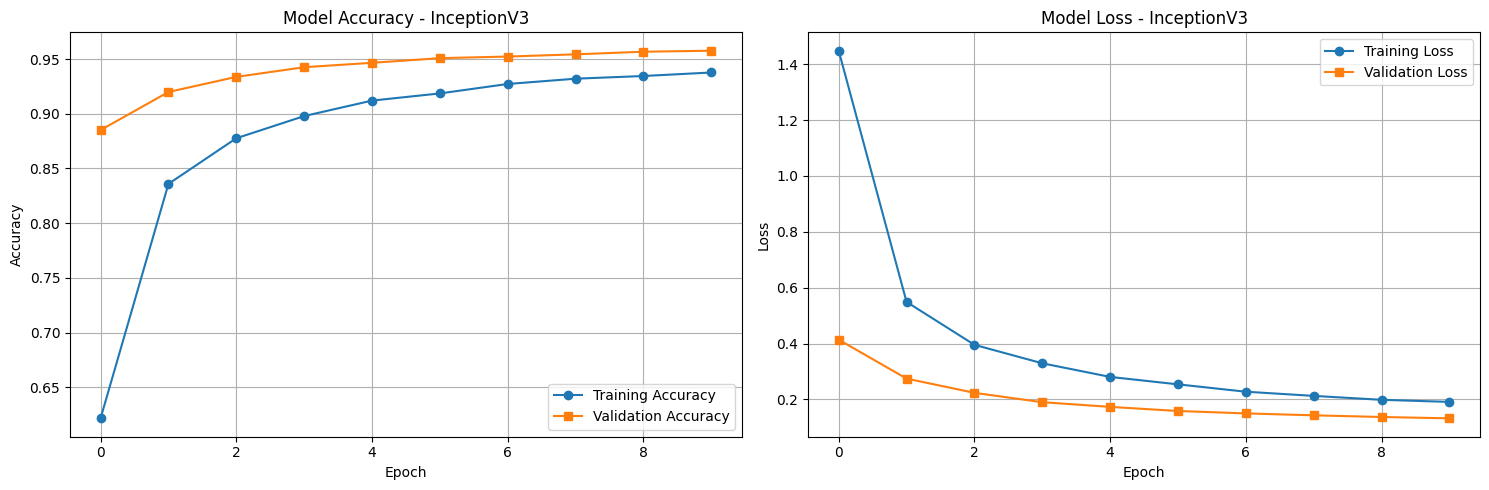

In [20]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0].set_title('Model Accuracy - InceptionV3')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[1].set_title('Model Loss - InceptionV3')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('inceptionv3_training_history.png', dpi=300, bbox_inches='tight')
plt.show()


## 8. Evaluate on Test Set


In [21]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(ds_test, verbose=1)
print(f"\n✓ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")

# Get predictions for detailed metrics
print("\nComputing predictions...")
y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("✓ Predictions completed")


Evaluating on test set...


2025-10-26 02:54:26.750930: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:54:26.755749: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:54:26.758355: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:54:26.762044: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:54:26.771354: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:54:26.775649: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:54:26.778213: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:54:26.781938: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:54:26.799796: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.


170/170 [==============================] - 61s 356ms/step - loss: 0.1412 - accuracy: 0.9536

✓ Test Accuracy: 95.36%
✓ Test Loss: 0.1412

Computing predictions...


2025-10-26 02:55:27.324340: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27.328778: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27.331268: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27.334857: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27.335782: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27.339922: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27.354174: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27.355609: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27.363916: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 02:55:27

✓ Predictions completed


In [22]:
# Calculate precision, recall, F1-score
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n=== Performance Metrics ===")
print(f"Accuracy:  {test_accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")
print(f"Training Time: {training_time/60:.2f} minutes")

# Store results
results = {
    'Model': 'InceptionV3',
    'Accuracy': test_accuracy*100,
    'Precision': precision*100,
    'Recall': recall*100,
    'F1-Score': f1*100,
    'Training Time (min)': training_time/60
}

# Create summary table
summary_df = pd.DataFrame([results])
print("\n=== Model Performance Summary ===")
print(summary_df.to_string(index=False))

# Save results to CSV
summary_df.to_csv('inceptionv3_results.csv', index=False)
print("\n✓ Results saved to 'inceptionv3_results.csv'")



=== Performance Metrics ===
Accuracy:  95.36%
Precision: 95.34%
Recall:    95.36%
F1-Score:  95.32%
Training Time: 95.48 minutes

=== Model Performance Summary ===
      Model  Accuracy  Precision    Recall  F1-Score  Training Time (min)
InceptionV3 95.359117  95.338998 95.359116 95.317299            95.478601

✓ Results saved to 'inceptionv3_results.csv'


## 9. Confusion Matrix


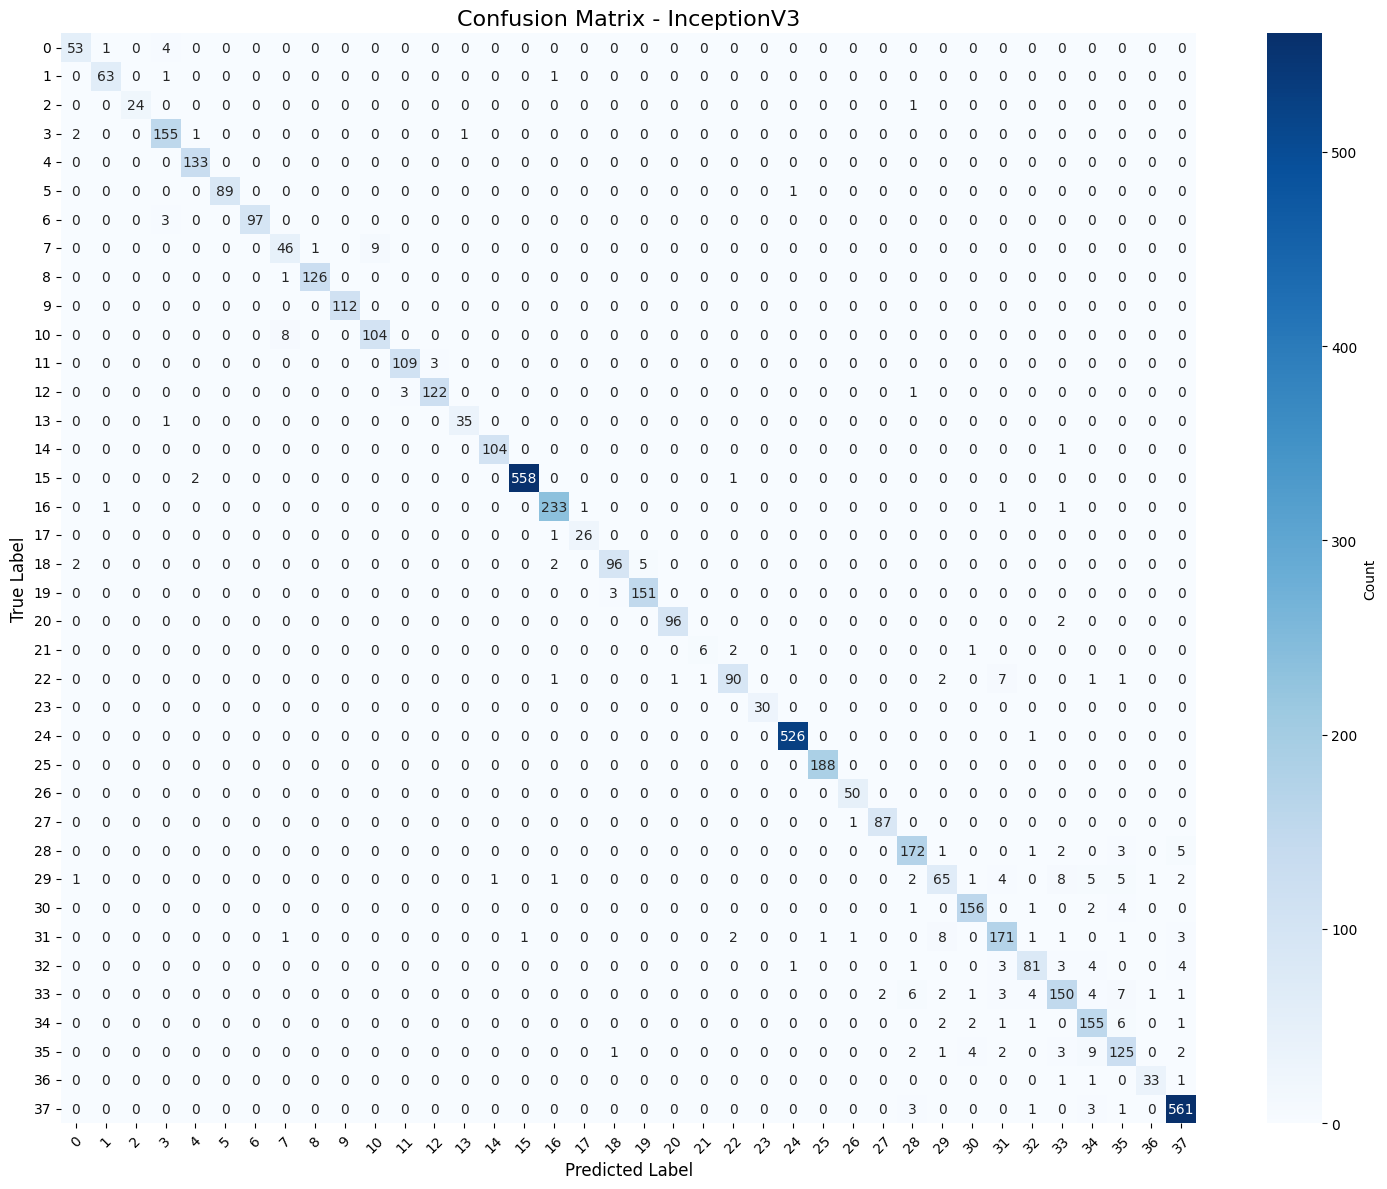

In [23]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - InceptionV3', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('inceptionv3_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()


Loading saved model from: /home/husnain/PlantVillage-TransferLearning/best_inceptionv3_model.h5


✓ Model loaded successfully


2025-10-26 13:47:23.953852: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:23.962881: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:23.966700: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:23.988732: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:23.992859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:23.995222: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:24.000475: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:24.180651: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:24.187859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:24

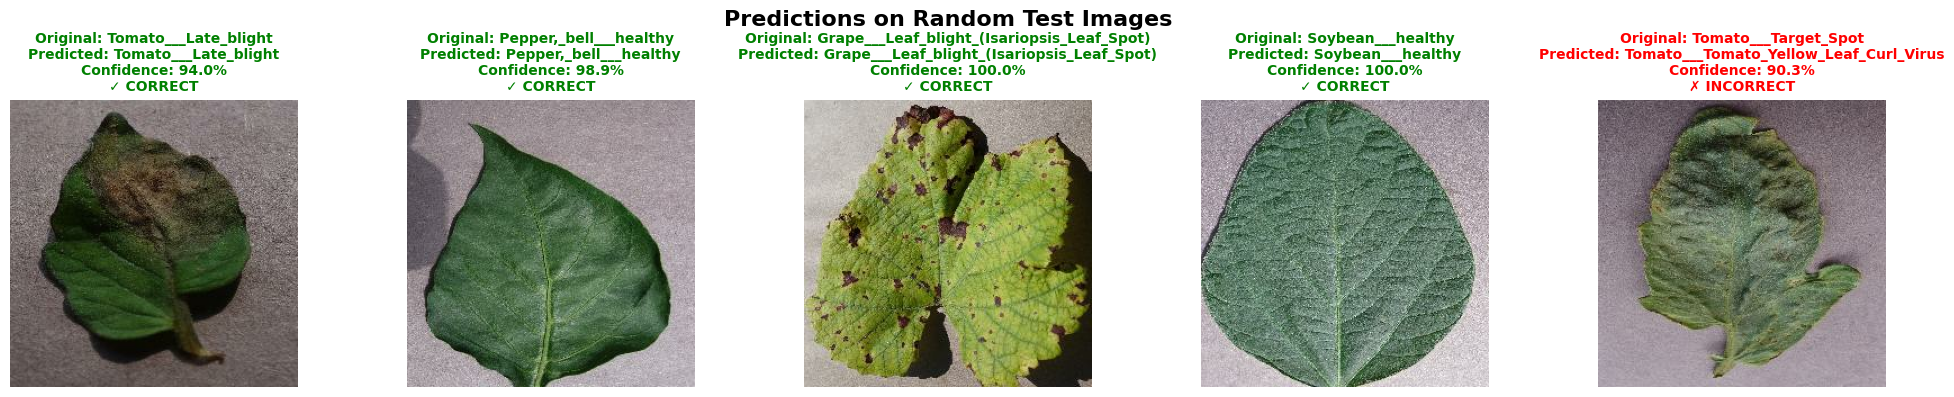


=== Prediction Summary for 5 Random Test Images ===

Image 1:
  Original Tag:  Tomato___Late_blight
  Predicted Tag: Tomato___Late_blight
  Confidence:    94.01%
  Result:        ✓ CORRECT

Image 2:
  Original Tag:  Pepper,_bell___healthy
  Predicted Tag: Pepper,_bell___healthy
  Confidence:    98.89%
  Result:        ✓ CORRECT


2025-10-26 13:47:26.102027: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26.110604: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26.115558: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26.127566: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26.131690: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26.134331: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26.211135: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26.218548: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26.223112: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-10-26 13:47:26


Image 3:
  Original Tag:  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
  Predicted Tag: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
  Confidence:    100.00%
  Result:        ✓ CORRECT

Image 4:
  Original Tag:  Soybean___healthy
  Predicted Tag: Soybean___healthy
  Confidence:    100.00%
  Result:        ✓ CORRECT

Image 5:
  Original Tag:  Tomato___Target_Spot
  Predicted Tag: Tomato___Tomato_Yellow_Leaf_Curl_Virus
  Confidence:    90.29%
  Result:        ✗ INCORRECT


In [6]:
# Load the saved best model
model_path = '/home/husnain/PlantVillage-TransferLearning/best_inceptionv3_model.h5'
print(f"Loading saved model from: {model_path}")
model = tf.keras.models.load_model(model_path)
print("✓ Model loaded successfully")

# Get class names from dataset info
class_names = info.features['label'].names

# Load raw test dataset for visualization (without preprocessing)
ds_test_raw = tfds.load('plant_village', split='train[90%:]', as_supervised=True)

# Convert to list and shuffle to get random images
test_images_list = list(ds_test_raw.take(1000))  # Take a subset for efficiency
np.random.shuffle(test_images_list)

# Select 5 random images
num_samples = 5
sample_images = test_images_list[:num_samples]

# Create figure with subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.suptitle('Predictions on Random Test Images', fontsize=16, fontweight='bold')

for idx, (image, label) in enumerate(sample_images):
    # Resize image for display
    image_resized = tf.image.resize(image, (299, 299))  # InceptionV3 requires 299x299
    image_array = tf.cast(image_resized, tf.float32) / 255.0
    
    # Make prediction
    prediction = model.predict(tf.expand_dims(image_array, 0), verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class] * 100
    
    # Get actual label
    actual_label_idx = label.numpy()
    
    # Display image
    axes[idx].imshow(image.numpy())
    axes[idx].axis('off')
    
    # Set title with original and predicted labels
    original_label = class_names[actual_label_idx]
    predicted_label = class_names[predicted_class]
    
    status = "✓ CORRECT" if actual_label_idx == predicted_class else "✗ INCORRECT"
    color = "green" if actual_label_idx == predicted_class else "red"
    
    axes[idx].set_title(
        f"Original: {original_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.1f}%\n{status}",
        fontsize=10,
        color=color,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('random_test_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\n=== Prediction Summary for 5 Random Test Images ===")
for idx, (image, label) in enumerate(sample_images):
    image_resized = tf.image.resize(image, (299, 299))  # InceptionV3 requires 299x299
    image_array = tf.cast(image_resized, tf.float32) / 255.0
    prediction = model.predict(tf.expand_dims(image_array, 0), verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = prediction[0][predicted_class] * 100
    actual_label_idx = label.numpy()
    
    original_label = class_names[actual_label_idx]
    predicted_label = class_names[predicted_class]
    status = "✓ CORRECT" if actual_label_idx == predicted_class else "✗ INCORRECT"
    
    print(f"\nImage {idx + 1}:")
    print(f"  Original Tag:  {original_label}")
    print(f"  Predicted Tag: {predicted_label}")
    print(f"  Confidence:    {confidence:.2f}%")
    print(f"  Result:        {status}")


## 10. Architecture Justification


In [24]:
print("="*80)
print(" ARCHITECTURE JUSTIFICATION - InceptionV3")
print("="*80)

print("\n1. THEORETICAL CONSIDERATIONS:")
print("   ✓ Inception Modules: Efficient multi-scale feature extraction")
print("   ✓ Factorized Convolutions: Reduces parameters while maintaining depth")
print("   ✓ Transfer Learning: Pre-trained on ImageNet with diverse features")
print("   ✓ Optimal Input Size: 299x299 provides rich spatial information")

print("\n2. PERFORMANCE BENEFITS:")
print("   ✓ Multi-scale feature detection for complex plant disease patterns")
print("   ✓ Efficient parameter utilization")
print("   ✓ Strong generalization from ImageNet knowledge")
print("   ✓ Robust to image variations and occlusions")

print("\n3. RESULTS SUMMARY:")
print(f"   ✓ Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   ✓ Precision:    {precision*100:.2f}%")
print(f"   ✓ Recall:        {recall*100:.2f}%")
print(f"   ✓ F1-Score:      {f1*100:.2f}%")
print(f"   ✓ Training Time: {training_time/60:.2f} minutes")

print("\n4. MODEL DEPLOYMENT:")
print("   ✓ Model saved as: 'best_inceptionv3_model.h5'")
print("   ✓ Training history: 'inceptionv3_training_history.png'")
print("   ✓ Confusion matrix: 'inceptionv3_confusion_matrix.png'")
print("   ✓ Results CSV:     'inceptionv3_results.csv'")

print("\n5. RECOMMENDATIONS:")
print("   ✓ Model is ready for deployment")
print("   ✓ Consider fine-tuning top layers for better performance")
print("   ✓ Data augmentation could further improve accuracy")
print("   ✓ Model demonstrates strong performance on plant disease detection")

print("\n" + "="*80)
print("✓ TRAINING COMPLETE")
print("="*80)


 ARCHITECTURE JUSTIFICATION - InceptionV3

1. THEORETICAL CONSIDERATIONS:
   ✓ Inception Modules: Efficient multi-scale feature extraction
   ✓ Factorized Convolutions: Reduces parameters while maintaining depth
   ✓ Transfer Learning: Pre-trained on ImageNet with diverse features
   ✓ Optimal Input Size: 299x299 provides rich spatial information

2. PERFORMANCE BENEFITS:
   ✓ Multi-scale feature detection for complex plant disease patterns
   ✓ Efficient parameter utilization
   ✓ Strong generalization from ImageNet knowledge
   ✓ Robust to image variations and occlusions

3. RESULTS SUMMARY:
   ✓ Test Accuracy: 95.36%
   ✓ Precision:    95.34%
   ✓ Recall:        95.36%
   ✓ F1-Score:      95.32%
   ✓ Training Time: 95.48 minutes

4. MODEL DEPLOYMENT:
   ✓ Model saved as: 'best_inceptionv3_model.h5'
   ✓ Training history: 'inceptionv3_training_history.png'
   ✓ Confusion matrix: 'inceptionv3_confusion_matrix.png'
   ✓ Results CSV:     'inceptionv3_results.csv'

5. RECOMMENDATIONS:
  